**Notebook Outline:**  
  
- [Setup with libraries](#Set-up-Cells)
- [Tokyo Mortality Dataset](#Tokyo-Mortality-Dataset)
- [Univariate example](#Univariate-example)
    - [Bandwidth: Random initialization check](#Bandwidth:-Random-initialization-check)
    - [Parameter check](Parameter-check)
- [Multivariate example](#Multivariate-example)
    [Bandwidths: Random initialization check](#Bandwidths:-Random-initialization-check)
- [MGWR bandwidths](#MGWR-bandwidths)
- [AIC, AICc, BIC check](#AIC,-AICc,-BIC-check)

Branch - gsco19

PR - https://github.com/pysal/mgwr/pull/60

### Set up Cells

In [1]:
import sys
#append path here to point to your folder
sys.path.append("C:/Users/msachde1/Downloads/Research/Development/mgwr")

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np

from mgwr.gwr import GWR
from spglm.family import Gaussian, Binomial, Poisson
from mgwr.gwr import MGWR
from mgwr.sel_bw import Sel_BW
import multiprocessing as mp
pool = mp.Pool()
from scipy import linalg
import numpy.linalg as la
from scipy import sparse as sp
from scipy.sparse import linalg as spla
from spreg.utils import spdot, spmultiply
from scipy import special
import libpysal as ps
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
import copy
from collections import namedtuple
import spglm

### Tokyo Mortality Dataset

In [3]:
data_p = ps.io.open(ps.examples.get_path('Tokyomortality.csv'))
coords = list(zip(data_p.by_col('X_CENTROID'),data_p.by_col('Y_CENTROID')))
off = np.array(data_p.by_col('eb2564')).reshape((-1,1))
y = np.array(data_p.by_col('db2564')).reshape((-1,1)) 
occ = np.array(data_p.by_col('OCC_TEC')).reshape((-1,1))
own = np.array(data_p.by_col('OWNH')).reshape((-1,1))
pop = np.array(data_p.by_col('POP65')).reshape((-1,1))
unemp = np.array(data_p.by_col('UNEMP')).reshape((-1,1))
#X set for multivariate example
X = np.hstack([occ,own,pop,unemp])
#x set for univariate example
x = occ

In [4]:
X_std = (X-X.mean(axis=0))/X.std(axis=0)
x_std = (x-x.mean(axis=0))/x.std(axis=0)
y_std = (y-y.mean(axis=0))/y.std(axis=0)
off_std = (off-off.mean(axis=0))/off.std(axis=0)

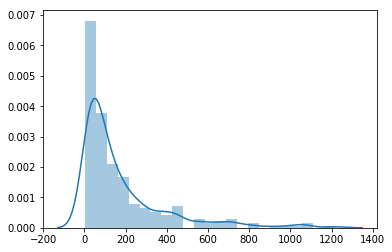

In [5]:
#checking distribution of y
sns.distplot(y)

### Univariate example

#### First example: checking GWR and MGWR models with one independent variable and constant = False

In [6]:
bw=Sel_BW(coords,y,x_std,family=Poisson(),offset=off,constant=False)
bw=bw.search()
gwr_model=GWR(coords,y,x_std,bw,family=Poisson(),offset=off,constant=False).fit()

In [7]:
bw

43.0

In [8]:
selector=Sel_BW(coords,y,x_std,multi=True,family=Poisson(),offset=off,constant=False)

In [9]:
selector.search(verbose=True)

Current iteration: 1 ,SOC: 0.0
Bandwidths: 43.0


array([43.])

In [10]:
mgwr_model=MGWR(coords,y,x_std,selector,family=Poisson(),offset=off,constant=False).fit()

#### Bandwidth: Random initialization check

In [ ]:
selector.search(verbose=True,init_multi=100)

#### Parameter check

In [11]:
y.shape[0]

262

In [12]:
np.sum(((gwr_model.params-mgwr_model.params)==0.0)==True)

262

In [13]:
gwr_model.aic,mgwr_model.aic

(619.7791467932716, 621.8839585099654)

In [14]:
np.sum((gwr_model.predy-mgwr_model.predy==0)==True)

262

### Multivariate example

In [15]:
bw=Sel_BW(coords,y,X_std,family=Poisson(),offset=off)
bw=bw.search()
gwr_model=GWR(coords,y,X_std,bw,family=Poisson(),offset=off).fit()

In [16]:
bw

107.0

In [17]:
selector=Sel_BW(coords,y,X_std,multi=True,family=Poisson(),offset=off)

In [18]:
selector.search(verbose=True)

Current iteration: 1 ,SOC: 0.0002848
Bandwidths: 64.0, 66.0, 83.0, 95.0, 44.0
Current iteration: 2 ,SOC: 0.0001778
Bandwidths: 171.0, 65.0, 105.0, 95.0, 44.0
Current iteration: 3 ,SOC: 7.21e-05
Bandwidths: 241.0, 65.0, 134.0, 106.0, 44.0
Current iteration: 4 ,SOC: 4.75e-05
Bandwidths: 261.0, 65.0, 212.0, 95.0, 44.0
Current iteration: 5 ,SOC: 2.22e-05
Bandwidths: 261.0, 65.0, 261.0, 95.0, 44.0
Current iteration: 6 ,SOC: 1.52e-05
Bandwidths: 260.0, 65.0, 261.0, 95.0, 44.0
Current iteration: 7 ,SOC: 1.57e-05
Bandwidths: 261.0, 65.0, 261.0, 95.0, 45.0
Current iteration: 8 ,SOC: 1.4e-05
Bandwidths: 261.0, 65.0, 261.0, 95.0, 44.0
Current iteration: 9 ,SOC: 1.09e-05
Bandwidths: 261.0, 65.0, 261.0, 95.0, 44.0
Current iteration: 10 ,SOC: 9.2e-06
Bandwidths: 261.0, 65.0, 261.0, 95.0, 44.0


array([261.,  65., 261.,  95.,  44.])

#### Bandwidths: Random initialization check

In [ ]:
selector.search(verbose=True, init_multi=50)

In [19]:
mgwr_model=MGWR(coords,y,X_std,selector,family=Poisson(),offset=off).fit()

### AIC, AICc, BIC check

In [20]:
mgwr_model.aicc,gwr_model.aicc

(362.36478481908165, 368.06775592811084)

In [ ]:
mgwr_model.aic,gwr_model.aic

In [ ]:
mgwr_model.bic,gwr_model.bic